# Random Walk Model for Panda Trajectory
This notebook implements the simulation of a panda's stepwise random walk, noisy measurement generation, noise variance identification using residuals, calculation of optimal exponential smoothing coefficient, smoothing, and visualization for two cases (3000 and 300 points).

## 1. Generate the panda's true trajectory
Simulate the true position trajectory $X_i$ using the random walk model:

\[X_i = X_{i-1} + w_i\]

with normally distributed noise $w_i \sim \mathcal{N}(0, \sigma_w^2)$.

Parameters:
- $\sigma_w^2 = 12$
- Initial position $X_1 = 10$ m
- Two cases for number of points: 3000 and 300.

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_random_walk(n_points, sigma_w_sq, sigma_eta_sq, init_pos=10):
    # Simulate true trajectory
    wi = np.random.normal(0, np.sqrt(sigma_w_sq), n_points)
    Xi = np.zeros(n_points)
    Xi[0] = init_pos
    for i in range(1, n_points):
        Xi[i] = Xi[i-1] + wi[i]
    # Generate noisy measurements
    eta = np.random.normal(0, np.sqrt(sigma_eta_sq), n_points)
    z = Xi + eta
    return Xi, z, wi, eta


## 2. Generate noisy measurements
Add measurement noise to the true trajectory:

\[z_i = X_i + \eta_i\]

where $\eta_i \sim \mathcal{N}(0, \sigma_\eta^2)$ with $\sigma_\eta^2 = 9$.

This is included in the `simulate_random_walk` function above, which returns both the true trajectory and noisy measurements.

## 3. Identify process and measurement noise variances

In [71]:
def identify_noise_variances(wi, eta):
    # Compute residuals
    v = wi[1:] + eta[1:] - eta[:-1]
    p = wi[2:] + wi[1:-1] + eta[2:] - eta[:-2]
    E_v2 = np.mean(v**2)
    E_p2 = np.mean(p**2)
    # Solve the system:
    # E[v^2] = sigma_w^2 + 2*sigma_eta^2
    # E[p^2] = 2*sigma_w^2 + 2*sigma_eta^2
    A = np.array([[1, 2], [2, 2]])
    b = np.array([E_v2, E_p2])
    sigma_w_sq_hat, sigma_eta_sq_hat = np.linalg.solve(A, b)
    return sigma_w_sq_hat, sigma_eta_sq_hat


## 4. Calculate optimal smoothing coefficient
Calculate exponential smoothing coefficient $\alpha$ with:

\[\alpha = \frac{-\chi + \sqrt{\chi^2 + 4\chi}}{2}, \quad \chi = \frac{\sigma_w^2}{\sigma_\eta^2}\]

In [72]:
def calc_optimal_alpha(sigma_w_sq, sigma_eta_sq):
    chi = sigma_w_sq / sigma_eta_sq
    alpha = (-chi + np.sqrt(chi**2 + 4*chi)) / 2
    return alpha


## 5. Exponential smoothing
Smooth measurements $z$ using exponential smoothing with coefficient $\alpha$:

\[s_i = \alpha z_i + (1-\alpha) s_{i-1}\]

where $s_0 = z_0$.

In [73]:
def exponential_smoothing(z, alpha):
    s = np.zeros_like(z)
    s[0] = z[0]
    for i in range(1, len(z)):
        s[i] = alpha * z[i] + (1 - alpha) * s[i-1]
    return s


## Full processing function
Run all steps for a given trajectory size and plot results.

In [74]:
def process_panda_trajectory(n_points, sigma_w_sq=12, sigma_eta_sq=9, init_pos=10):
    print(f"Processing panda trajectory with {n_points} points")
    Xi, z, wi, eta = simulate_random_walk(n_points, sigma_w_sq, sigma_eta_sq, init_pos)
    sigma_w_hat, sigma_eta_hat = identify_noise_variances(wi, eta)
    print(f"Estimated \u03C3_w^2: {sigma_w_hat:.2f} (true {sigma_w_sq})")
    print(f"Estimated \u03C3_\u03B7^2: {sigma_eta_hat:.2f} (true {sigma_eta_sq})")
    alpha = calc_optimal_alpha(sigma_w_hat, sigma_eta_hat)
    print(f"Optimal smoothing coefficient \u03B1: {alpha:.3f}")
    smoothed = exponential_smoothing(z, alpha)

    plt.figure(figsize=(8,5))
    plt.plot(Xi, label='True Trajectory', linewidth=1)
    plt.plot(z, label='Noisy Measurements', alpha=0.6)
    plt.plot(smoothed, label='Exponentially Smoothed', linewidth=2)
    plt.xlabel('Step')
    plt.ylabel('Position (m)')
    plt.title(f'Panda Trajectory Analysis (n = {n_points})')
    plt.legend()
    plt.show()
    
    return {
        'true_trajectory': Xi,
        'measurements': z,
        'sigma_w_hat': sigma_w_hat,
        'sigma_eta_hat': sigma_eta_hat,
        'alpha': alpha,
        'smoothed': smoothed
    }


## Run analysis for 3000 points

Processing panda trajectory with 3000 points
Estimated σ_w^2: 11.98 (true 12)
Estimated σ_η^2: 8.36 (true 9)
Optimal smoothing coefficient α: 0.679


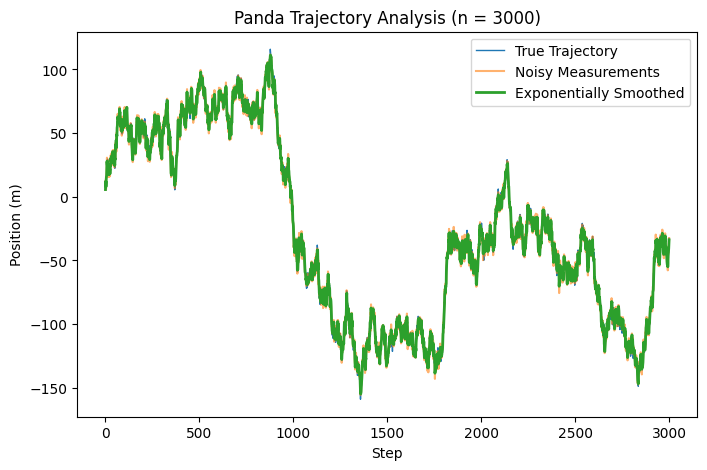

In [75]:
results_3000 = process_panda_trajectory(3000)

## Run analysis for 300 points

Processing panda trajectory with 300 points
Estimated σ_w^2: 17.55 (true 12)
Estimated σ_η^2: 6.21 (true 9)
Optimal smoothing coefficient α: 0.783


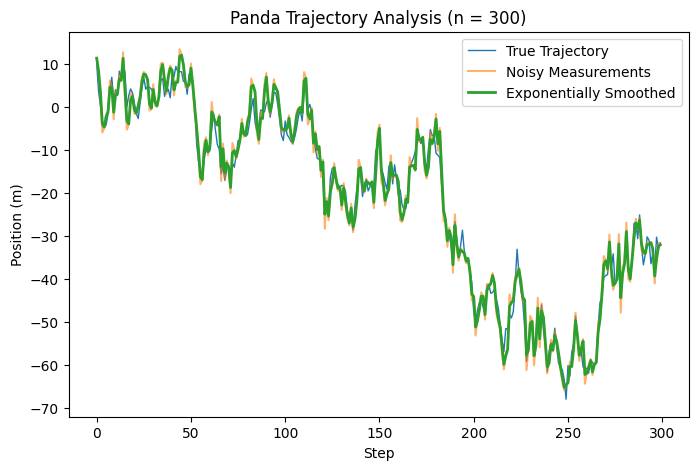

In [76]:
results_300 = process_panda_trajectory(300)